In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Loading Images from the Disk

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../datasets-4",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2814 files belonging to 4 classes.


2023-05-19 10:51:07.086136: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-19 10:51:07.181230: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-19 10:51:07.182605: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-19 10:51:07.184970: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Splitting the Dataset

We will take -
- 80% data for training our model
- 10% data for validation purpose
- 10% data for test purpose

In [4]:
total_batches = len(dataset)
train_size = int(0.75 * total_batches)
test_size = int(0.10 * total_batches)
val_size = total_batches - train_size - test_size

print(f"""
    Total Batches: {total_batches},
    Training Batches: {train_size},
    Testing Batches: {test_size},
    Validation Batches: {val_size}
""")

train_ds = dataset.take(train_size) # used for training data
test_ds = dataset.skip(train_size).take(test_size) # final evaluation will be done on this model
val_ds = dataset.skip(train_size + test_size).take(val_size) # used to tune the model


    Total Batches: 88,
    Training Batches: 66,
    Testing Batches: 8,
    Validation Batches: 14



## Cache, Shuffle, and Prefetch the Dataset

In [5]:
train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(2000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(2000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Image Augmentation

In [7]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

# Applying Augmentation on Training Data
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Designing and Training the Model

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(dataset.class_names)

In [18]:
# Load pre-trained ResNet50 model
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_tensor=Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    pooling=None
)

In [19]:
# Freeze the base model's layers
base_model.trainable = False

# Create new model on top of the pre-trained base model
inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(len(dataset.class_names), activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

In [20]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                             

In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=10
)

# Save the best model with the least validation loss
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath="finalproject_weights.h5",
    verbose=1,
    save_best_only=True
)

In [14]:
history = model.fit(
    train_ds, 
    epochs = 50,
    validation_data=val_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    callbacks=[early_stopping, checkpointer]
)

Epoch 1/50


2023-05-17 14:26:09.307761: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 20382276 exceeds 10% of free system memory.
2023-05-17 14:26:09.315080: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 26847210 exceeds 10% of free system memory.
2023-05-17 14:26:09.318979: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 26802336 exceeds 10% of free system memory.
2023-05-17 14:26:09.332187: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 26505000 exceeds 10% of free system memory.
2023-05-17 14:26:09.481627: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 26451000 exceeds 10% of free system memory.
2023-05-17 14:26:19.810929: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 13 of 2000
2023-05-17 14:26:29.639991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 35 of 2000
2023

 1/66 [..............................] - ETA: 48:17 - loss: 2.6923 - accuracy: 0.1562

2023-05-17 14:26:50.367423: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-05-17 14:26:50.367507: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-05-17 14:26:50.419379: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-05-17 14:26:50.419420: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Alloc

66/66 [==============================] - ETA: 0s - loss: 1.1476 - accuracy: 0.5374

2023-05-17 14:27:44.109396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 2000
2023-05-17 14:27:44.506441: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2 of 2000
2023-05-17 14:27:45.100134: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 2000
2023-05-17 14:27:45.817967: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 4 of 2000
2023-05-17 14:27:47.085242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-17 14:27:48.532987: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


Epoch 1: val_loss improved from inf to 0.58648, saving model to finalproject_weights.h5
66/66 [==============================] - 106s 945ms/step - loss: 1.1476 - accuracy: 0.5374 - val_loss: 0.5865 - val_accuracy: 0.7578
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 0.6161 - accuracy: 0.7519
Epoch 2: val_loss improved from 0.58648 to 0.44874, saving model to finalproject_weights.h5
66/66 [==============================] - 17s 254ms/step - loss: 0.6161 - accuracy: 0.7519 - val_loss: 0.4487 - val_accuracy: 0.8049
Epoch 3/50
66/66 [==============================] - ETA: 0s - loss: 0.4845 - accuracy: 0.8073
Epoch 3: val_loss improved from 0.44874 to 0.34282, saving model to finalproject_weights.h5
66/66 [==============================] - 17s 254ms/step - loss: 0.4845 - accuracy: 0.8073 - val_loss: 0.3428 - val_accuracy: 0.8565
Epoch 4/50
66/66 [==============================] - ETA: 0s - loss: 0.4033 - accuracy: 0.8352
Epoch 4: val_loss improved from 0.34282 to 0.303

## Model Evaluation

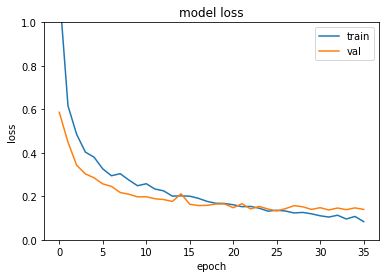

In [17]:
# The is how training loss and validation loss varied during training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.ylim(0, 1)
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

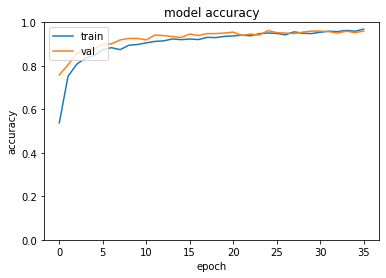

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
# Save the model architecture
model_json = model.to_json()
with open("finalproject_model.json", "w") as json_file:
    json_file.write(model_json)

## Evaluating the Saved Model Performance

In [6]:
# Load the pretrained model (best saved one)
with open('finalproject_model.json', 'r') as json_file:
    json_saved_model = json_file.read()

# Load the model
model = tf.keras.models.model_from_json(json_saved_model)
model.load_weights('finalproject_weights.h5')
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='Adam', metrics=["accuracy"])


In [7]:
scores = model.evaluate(test_ds)

2023-05-19 10:51:52.117572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 2000
2023-05-19 10:51:52.474769: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2 of 2000
2023-05-19 10:51:54.716736: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-19 10:51:55.730599: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8204
2023-05-19 10:51:56.835250: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/8 [==>...........................] - ETA: 3:52 - loss: 0.1117 - accuracy: 0.9375

2023-05-19 10:51:59.568205: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-05-19 10:51:59.568260: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-05-19 10:51:59.627238: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-05-19 10:51:59.627271: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Alloc

8/8 [==============================] - 35s 221ms/step - loss: 0.1081 - accuracy: 0.9531


In [8]:
predict = []
y_test = np.array([])
for images, labels in test_ds:
    y_test = np.concatenate((y_test, labels.numpy()), axis=0).astype(int)
    predictions = model.predict(images)
    predict.extend(np.argmax(predictions, axis=1))
predict = np.asarray(predict)

In [13]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
for images, labels in test_ds:
    predictions = model.predict(images)
    print(predictions)
    # print(images)
    for image in images:
        print(image)
        break
    break

[[0.000 0.976 0.000 0.024]
 [0.000 0.000 0.000 1.000]
 [0.000 0.017 0.983 0.000]
 [0.000 0.060 0.940 0.000]
 [0.962 0.037 0.000 0.000]
 [0.000 0.001 0.000 0.999]
 [0.001 0.872 0.118 0.009]
 [1.000 0.000 0.000 0.000]
 [0.997 0.000 0.002 0.001]
 [1.000 0.000 0.000 0.000]
 [0.001 0.998 0.001 0.000]
 [0.993 0.000 0.007 0.000]
 [0.000 0.000 0.000 1.000]
 [1.000 0.000 0.000 0.000]
 [0.005 0.001 0.995 0.000]
 [0.000 1.000 0.000 0.000]
 [1.000 0.000 0.000 0.000]
 [0.000 1.000 0.000 0.000]
 [1.000 0.000 0.000 0.000]
 [0.000 0.106 0.004 0.890]
 [0.000 0.830 0.169 0.000]
 [0.000 0.997 0.001 0.002]
 [0.000 0.000 0.000 1.000]
 [0.996 0.001 0.002 0.001]
 [0.000 0.209 0.790 0.000]
 [0.000 0.780 0.000 0.219]
 [1.000 0.000 0.000 0.000]
 [1.000 0.000 0.000 0.000]
 [0.000 0.029 0.000 0.970]
 [0.000 0.066 0.000 0.934]
 [0.000 0.906 0.094 0.000]
 [0.000 0.000 0.000 1.000]]
tf.Tensor(
[[[19.932 19.932 19.932]
  [20.105 20.105 20.105]
  [21.000 21.000 21.000]
  ...
  [29.105 29.105 29.105]
  [20.238 20.238 2

In [13]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predict)
print(f"Accuracy: {accuracy}")

Accuracy: 0.953125


<AxesSubplot:>

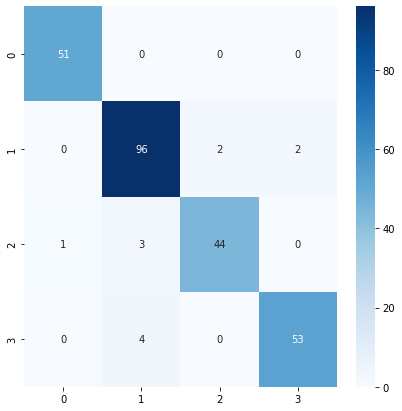

In [14]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True, cmap='Blues')

In [15]:
from sklearn.metrics import classification_report

report = classification_report(y_test, predict)
print(report)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        51
           1       0.93      0.96      0.95       100
           2       0.96      0.92      0.94        48
           3       0.96      0.93      0.95        57

    accuracy                           0.95       256
   macro avg       0.96      0.95      0.95       256
weighted avg       0.95      0.95      0.95       256

